# ***🚀 Email Spam Detection 🚀***

# ***AIMS***

Our aim is to get the best model with the best RMSLE score.
- First, we will conduct some basic EDA.
- Then, we will perform Pre-processing and encoding.
- Finally, we'll use some famous algorithms to get the best model.


***1. Introduction***

This notebook presents a step-by-step guide to building an efficient SMS spam classification model using the SMS Spam Collection dataset.By the end of this notebook, you'll have a reliable tool to help filter out unwanted messages, making your text messaging experience smoother and safer. 😊

***2. Problem Statement***

The primary goal of this notebook is to develop a predictive model that accurately classifies incoming SMS messages as either ham or spam. We will use the SMS Spam Collection dataset, which consists of 5,574 SMS messages tagged with their respective labels.

***3.Import Libraries***

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
# import porter stemmer
from nltk.stem import PorterStemmer
import string
# import label encoder
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
import nltk
from wordcloud import WordCloud

# Import the necessary machine learning models from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB  # Assuming you mean MultinomialNB for Naive Bayes
from sklearn.svm import SVC  # Support Vector Classification
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#CounterVectorizer Convert the text into matrics
from sklearn.feature_extraction.text import CountVectorizer

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', None)

print("Libraries Imported Successfully!")


Libraries Imported Successfully!


In [2]:
# Import necessary modules for dataset handling in Colab
from google.colab import files
import pandas as pd
import io

# Upload the dataset
uploaded = files.upload()

# Automatically get the uploaded file name
file_name = list(uploaded.keys())[0]

# Load the dataset into a DataFrame, specifying the encoding as 'latin-1'
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding='latin-1')

# Display the first 5 rows of the dataset
df.head()

Saving spam.csv to spam (3).csv


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [4]:
#Rename the columns
df.rename(columns={'v1':'Category','v2':'Masseges'},inplace=True)


In [5]:
df.head()

,Category,Masseges
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


***4. Statistical Overview🔍***

In [6]:
# Check basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Masseges  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.describe()

,Category,Masseges
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Text(0.5, 1.0, 'Distrubution of Category')

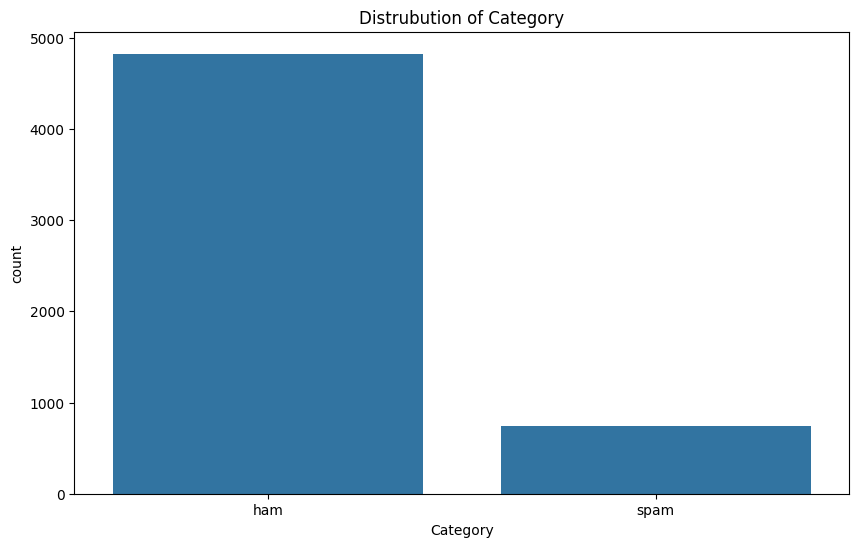

In [8]:
# Make bar plot on category column

cat = df['Category'].value_counts()

# Make plot  distrubution plot
import seaborn as sns # import the seaborn library and alias it as sns
plt.figure(figsize=(10,6))
sns.barplot(x=cat.index, y=cat)
plt.title("Distrubution of Category")

***5. Data Cleaning***

In [9]:
# check null values
df.isnull().sum().sort_values(ascending=False)

,0
Category,0
Masseges,0


In [10]:
# Remove duplicates values
df.drop_duplicates(inplace=True)

In [11]:
# Encode Category column
le = LabelEncoder()
df['Category']=le.fit_transform(df['Category'])
df.head()

,Category,Masseges
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


***6. Text Pre-processing***

In [12]:
# Remove text to lower case
df['Masseges'] = df['Masseges'].str.lower()


In [13]:
df.head()


,Category,Masseges
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [14]:
# define a function to remove punctuation
df['Masseges'] = df['Masseges'].str.translate(str.maketrans('', '', string.punctuation))

In [15]:
# Remove html tags
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Apply the function to 'Massege' Column
df['Masseges'] = df['Masseges'].apply(remove_html)

In [16]:
# Remove extra white space
df['Masseges'] = df['Masseges'].str.strip()


In [17]:
def remove_non_alphanumeric(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)


# Apply to 'Massege' Column
df['Masseges'] = df['Masseges'].apply(remove_non_alphanumeric)


In [18]:
# Function to remove special characters
def remove_special_characters(text):
    # Replace all special characters (non-alphanumeric and non-whitespace) with an empty string
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

# Apply to 'Massege' Column
df['Masseges'] = df['Masseges'].apply(remove_special_characters)

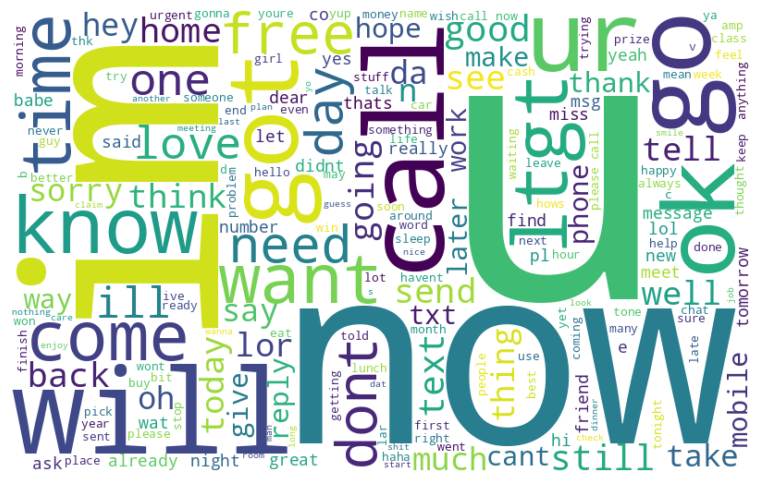

In [19]:
# check wordcloud
text=' '.join(df['Masseges'])
wordcloud=WordCloud(width=800,height=500,background_color='white').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df['Masseges'] = df['Masseges'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Function to remove numerical values from text
def remove_numerical_values(text):
    # Replace all numerical values with an empty string
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text


# Apply to 'Massege' Column
df['Masseges'] = df['Masseges'].apply(remove_numerical_values)

In [22]:
# Initialize the Porter Stemmer
porter_stemmer = PorterStemmer()

# Apply stemming
df['Message_stemmed'] = df['Masseges'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))

***7. Model Building***

In [23]:
# Intlize CountVectorizer
cv = CountVectorizer()

# Fitting CountVectorizer on X
X = cv.fit_transform(df['Message_stemmed']).toarray()
y = df['Category']


In [24]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)


In [25]:
#create models
bc = BaggingClassifier(n_estimators=50, random_state=42)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=42)
xgb = XGBClassifier(n_estimators=50, random_state=42)
svc = SVC(kernel="sigmoid", gamma=1.0)
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=10)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)


models = {
    'BGC': bc,
    'GBDT': gbdt,
    'xgb': xgb,
    'SVC': svc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'Adaboost': abc
}

def train_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    return accuracy, precision



***8. Evaluation***

In [26]:
accuracy_scores = []
precision_scores = []

# Iterate over the items in the clfs dictionary
for name, model in models.items():
    current_accuracy, current_precision = train_classifier(model, X_train, y_train, X_test, y_test)
    rounded_accuracy = round(current_accuracy, 2)
    rounded_precision = round(current_precision, 2)

    print()
    print("For: ", name)
    print("Accuracy: ", rounded_accuracy)
    print("Precision: ", rounded_precision)

    accuracy_scores.append(rounded_accuracy)
    precision_scores.append(rounded_precision)



For:  BGC
Accuracy:  0.97
Precision:  0.95

For:  GBDT
Accuracy:  0.96
Precision:  0.95

For:  xgb
Accuracy:  0.98
Precision:  0.97

For:  SVC
Accuracy:  0.93
Precision:  0.72

For:  NB
Accuracy:  0.98
Precision:  0.86

For:  DT
Accuracy:  0.95
Precision:  0.91

For:  LR
Accuracy:  0.98
Precision:  0.96

For:  RF
Accuracy:  0.97
Precision:  0.99

For:  Adaboost
Accuracy:  0.97
Precision:  0.92


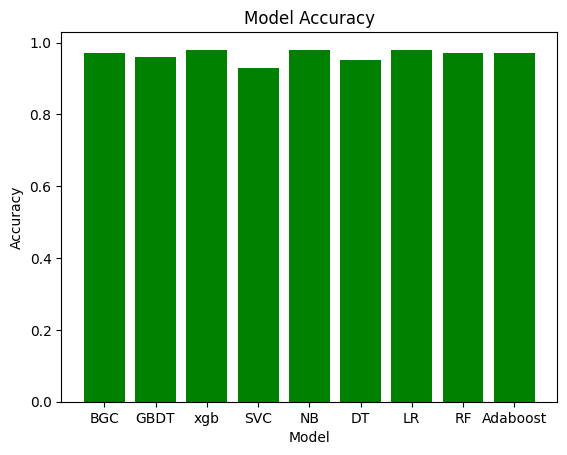

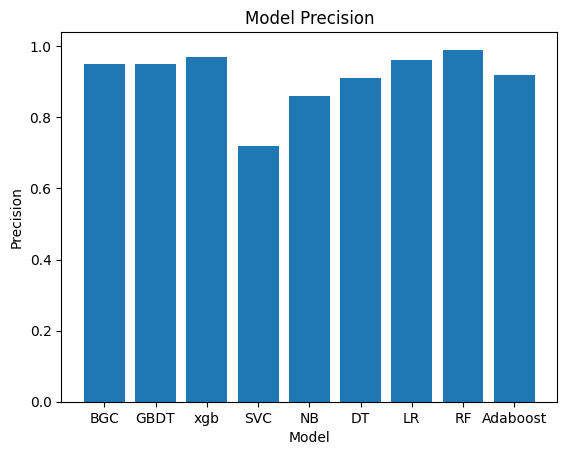

In [27]:
# Plot the accuracy scores
plt.bar(x=['BGC', 'GBDT', 'xgb', 'SVC', 'NB', 'DT', 'LR', 'RF', 'Adaboost'], height=accuracy_scores, color='green')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Plot the precision scores
plt.figure()
plt.bar(x=['BGC', 'GBDT', 'xgb', 'SVC', 'NB', 'DT', 'LR', 'RF', 'Adaboost'], height=precision_scores)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Model Precision')

plt.show()

In [28]:
# Save the model
import pickle
pickle.dump(mnb, open('model.pkl', 'wb'))